##### Copyright 2019 The TensorFlow Authors.


# Load CSV data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/csv"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/csv.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/csv.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/csv.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial provides examples of how to use CSV data with TensorFlow.

There are two main parts to this:

1. **Loading the data off disk**
2. **Pre-processing it into a form suitable for training.**

This tutorial focuses on the loading, and gives some quick examples of preprocessing. To learn more about the preprocessing aspect, check out the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.


## Setup

In [1]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

## Mixed data types

The "Titanic" dataset contains information about the passengers on the Titanic. The nominal task on this dataset is to predict who survived.

![The Titanic](images/csv/Titanic.jpg)

Image [from Wikimedia](https://commons.wikimedia.org/wiki/File:RMS_Titanic_3.jpg)

The raw data can easily be loaded as a Pandas `DataFrame`, but is not immediately usable as input to a TensorFlow model.


In [5]:
titanic = pd.read_csv("insurance_claims_v2.csv")
titanic.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
328,48,521585,17/10/2014,OH,250/500,1000,1406,91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,1.0
228,42,342868,27/06/2006,IN,250/500,2000,1197,22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,1.0
134,29,687698,06/09/2000,OH,100/300,2000,1413,14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0.0
256,41,227811,25/05/1990,IL,250/500,2000,1415,74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1.0
228,44,367455,06/06/2014,IL,500/1000,1000,1583,91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,0.0


In [6]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('fraud_reported')

Because of the different data types and ranges, you can't simply stack the features into a NumPy array and pass it to a `tf.keras.Sequential` model. Each column needs to be handled individually.

As one option, you could preprocess your data offline (using any tool you like) to convert categorical columns to numeric columns, then pass the processed output to your TensorFlow model. The disadvantage to that approach is that if you save and export your model the preprocessing is not saved with it. The Keras preprocessing layers avoid this problem because they're part of the model.


In this example, you'll build a model that implements the preprocessing logic using [Keras functional API](https://www.tensorflow.org/guide/keras/functional). You could also do it by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

The functional API operates on "symbolic" tensors. Normal "eager" tensors have a value. In contrast these "symbolic" tensors do not. Instead they keep track of which operations are run on them, and build a representation of the calculation, that you can run later. Here's a quick example:

In [7]:
# Create a symbolic input
input = tf.keras.Input(shape=(), dtype=tf.float32)

# Perform a calculation using the input
result = 2*input + 1

# the result doesn't have a value
result

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.__operators__.add')>

In [8]:
calc = tf.keras.Model(inputs=input, outputs=result)

In [9]:
print(calc(1).numpy())
print(calc(2).numpy())

3.0
5.0


To build the preprocessing model, start by building a set of symbolic `tf.keras.Input` objects, matching the names and data-types of the CSV columns.

In [10]:
inputs = {}

for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'months_as_customer': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'months_as_customer')>,
 'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'policy_number': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'policy_number')>,
 'policy_bind_date': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'policy_bind_date')>,
 'policy_state': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'policy_state')>,
 'policy_csl': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'policy_csl')>,
 'policy_deductable': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'policy_deductable')>,
 'policy_annual_premium': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'policy_annual_premium')>,
 'umbrella_limit': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'umbrella_limit')>,
 'insured_zip': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'insured_zip')>,
 'in

The first step in your preprocessing logic is to concatenate the numeric inputs together, and run them through a normalization layer:

In [11]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 13) dtype=float32 (created by layer 'normalization')>

Collect all the symbolic preprocessing results, to concatenate them later:

In [12]:
preprocessed_inputs = [all_numeric_inputs]

For the string inputs use the `tf.keras.layers.StringLookup` function to map from strings to integer indices in a vocabulary. Next, use `tf.keras.layers.CategoryEncoding` to convert the indexes into `float32` data appropriate for the model.

The default settings for the `tf.keras.layers.CategoryEncoding` layer create a one-hot vector for each input. A `tf.keras.layers.Embedding` would also work. Check out the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial for more on this topic.

In [13]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = layers.StringLookup(vocabulary=np.unique(titanic_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

With the collection of `inputs` and `preprocessed_inputs`, you can concatenate all the preprocessed inputs together, and build a model that handles the preprocessing:

In [14]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


This model just contains the input preprocessing. You can run it to see what it does to your data. Keras models don't automatically convert pandas `DataFrame`s because it's not clear if it should be converted to one tensor or to a dictionary of tensors. So, convert it to a dictionary of tensors:

In [15]:
titanic_features_dict = {name: np.array(value) 
                         for name, value in titanic_features.items()}

Slice out the first training example and pass it to this preprocessing model, you see the numeric features and string one-hots all concatenated together:

In [16]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 4379), dtype=float32, numpy=
array([[ 0.991, -0.096, -0.222, ...,  0.   ,  0.   ,  0.   ]],
      dtype=float32)>

Now, build the model on top of this:

In [17]:
def titanic_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam())
  return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

When you train the model, pass the dictionary of features as `x`, and the label as `y`.

In [18]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=10)

Epoch 1/10
32/32 [==============================] - 2s 5ms/step - loss: nan
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: nan
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: nan
Epoch 4/10
32/32 [==============================] - 0s 4ms/step - loss: nan
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: nan
Epoch 6/10
32/32 [==============================] - 0s 4ms/step - loss: nan
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: nan
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: nan
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: nan
Epoch 10/10
32/32 [==============================] - 0s 4ms/step - loss: nan


Since the preprocessing is part of the model, you can save the model and reload it somewhere else and get identical results:

In [19]:
titanic_model.save('test')
reloaded = tf.keras.models.load_model('test')

INFO:tensorflow:Assets written to: test\assets


INFO:tensorflow:Assets written to: test\assets


In [20]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}

before = titanic_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

AssertionError: 

## Using tf.data


In the previous section you relied on the model's built-in data shuffling and batching while training the model.

If you need more control over the input data pipeline or need to use data that doesn't easily fit into memory: use `tf.data`.

For more examples, refer to the [`tf.data`: Build TensorFlow input pipelines](../../guide/data.ipynb) guide.

### On in memory data

As a first example of applying `tf.data` to CSV data, consider the following code to manually slice up the dictionary of features from the previous section. For each index, it takes that index for each feature:


In [21]:
import itertools

def slices(features):
  for i in itertools.count():
    # For each feature take index `i`
    example = {name:values[i] for name, values in features.items()}
    yield example

Run this and print the first example:

In [22]:
for example in slices(titanic_features_dict):
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

months_as_customer : 48
age                : 521585
policy_number      : 17/10/2014
policy_bind_date   : OH
policy_state       : 250/500
policy_csl         : 1000
policy_deductable  : 1406
policy_annual_premium: 91
umbrella_limit     : 0
insured_zip        : 466132
insured_sex        : MALE
insured_education_level: MD
insured_occupation : craft-repair
insured_hobbies    : sleeping
insured_relationship: husband
capital-gains      : 53300
capital-loss       : 0
incident_date      : 25/01/2015
incident_type      : Single Vehicle Collision
collision_type     : Side Collision
incident_severity  : Major Damage
authorities_contacted: Police
incident_state     : SC
incident_city      : Columbus
incident_location  : 9935 4th Drive
incident_hour_of_the_day: 5
number_of_vehicles_involved: 1
property_damage    : YES
bodily_injuries    : 1
witnesses          : 2
police_report_available: YES
total_claim_amount : 71610
injury_claim       : 6510
property_claim     : 13020
vehicle_claim      : 52080
au

The most basic `tf.data.Dataset` in memory data loader is the `Dataset.from_tensor_slices` constructor. This returns a `tf.data.Dataset` that implements a generalized version of the above `slices` function, in TensorFlow.

In [23]:
features_ds = tf.data.Dataset.from_tensor_slices(titanic_features_dict)

You can iterate over a `tf.data.Dataset` like any other python iterable:

In [24]:
for example in features_ds:
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

months_as_customer : 48
age                : 521585
policy_number      : b'17/10/2014'
policy_bind_date   : b'OH'
policy_state       : b'250/500'
policy_csl         : 1000
policy_deductable  : 1406
policy_annual_premium: 91
umbrella_limit     : 0
insured_zip        : b'466132'
insured_sex        : b'MALE'
insured_education_level: b'MD'
insured_occupation : b'craft-repair'
insured_hobbies    : b'sleeping'
insured_relationship: b'husband'
capital-gains      : 53300
capital-loss       : b'0'
incident_date      : b'25/01/2015'
incident_type      : b'Single Vehicle Collision'
collision_type     : b'Side Collision'
incident_severity  : b'Major Damage'
authorities_contacted: b'Police'
incident_state     : b'SC'
incident_city      : b'Columbus'
incident_location  : b'9935 4th Drive'
incident_hour_of_the_day: 5
number_of_vehicles_involved: b'1'
property_damage    : b'YES'
bodily_injuries    : 1
witnesses          : b'2'
police_report_available: b'YES'
total_claim_amount : 71610
injury_claim    

The `from_tensor_slices` function can handle any structure of nested dictionaries or tuples. The following code makes a dataset of `(features_dict, labels)` pairs:

In [25]:
titanic_ds = tf.data.Dataset.from_tensor_slices((titanic_features_dict, titanic_labels))

To train a model using this `Dataset`, you'll need to at least `shuffle` and `batch` the data.

In [26]:
titanic_batches = titanic_ds.shuffle(len(titanic_labels)).batch(32)

Instead of passing `features` and `labels` to `Model.fit`, you pass the dataset:

In [27]:
titanic_model.fit(titanic_batches, epochs=5)

Epoch 1/5
32/32 [==============================] - 1s 5ms/step - loss: nan
Epoch 2/5
32/32 [==============================] - 0s 5ms/step - loss: nan
Epoch 3/5
32/32 [==============================] - 0s 5ms/step - loss: nan
Epoch 4/5
32/32 [==============================] - 0s 5ms/step - loss: nan
Epoch 5/5
32/32 [==============================] - 0s 5ms/step - loss: nan


### From a single file

So far this tutorial has worked with in-memory data. `tf.data` is a highly scalable toolkit for building data pipelines, and provides a few functions for dealing loading CSV files. 

In [33]:
titanic_file_path = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

Now read the CSV data from the file and create a `tf.data.Dataset`.

(For the full documentation, see `tf.data.experimental.make_csv_dataset`)


In [38]:
titanic_csv_ds = tf.data.experimental.make_csv_dataset(
    "insurance_claims.csv",
    batch_size=5, # Artificially small to make examples easier to show.
    label_name='fraud_reported',
    num_epochs=1,
    ignore_errors=True,)

This function includes many convenient features, so the data is easy to work with. This includes:

* Using the column headers as dictionary keys.
* Automatically determining the type of each column.

Caution: Make sure to set the `num_epochs` argument in `tf.data.experimental.make_csv_dataset`, otherwise the default behavior for `tf.data.Dataset` is to loop endlessly.

In [39]:
for batch, label in titanic_csv_ds.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value}")
  print()
  print(f"{'label':20s}: {label}")

months_as_customer  : [212 246 242 140 166]
age                 : [35 43 40 30 37]
policy_number       : [620855 805806 118137 521592 352120]
policy_bind_date    : [b'1990-04-29' b'2013-01-16' b'1998-02-10' b'2014-06-15' b'1994-12-11']
policy_state        : [b'IN' b'IN' b'OH' b'IL' b'IN']
policy_csl          : [b'500/1000' b'250/500' b'100/300' b'100/300' b'250/500']
policy_deductable   : [2000 1000  500  500  500]
policy_annual_premium: [1123.89 1267.4  1238.65 1354.2  1518.54]
umbrella_limit      : [      0 6000000       0       0       0]
insured_zip         : [468313 454139 468702 438775 470510]
insured_sex         : [b'MALE' b'MALE' b'FEMALE' b'FEMALE' b'FEMALE']
insured_education_level: [b'MD' b'JD' b'High School' b'College' b'MD']
insured_occupation  : [b'priv-house-serv' b'adm-clerical' b'transport-moving' b'adm-clerical'
 b'craft-repair']
insured_hobbies     : [b'video-games' b'basketball' b'bungie-jumping' b'bungie-jumping'
 b'kayaking']
insured_relationship: [b'unmarried' b'

Note: If you run the above cell twice it will produce different results. The default settings for `tf.data.experimental.make_csv_dataset` include `shuffle_buffer_size=1000`, which is more than sufficient for this small dataset, but may not be for a real-world dataset.

It can also decompress the data on the fly. Here's a gzipped CSV file containing the [metro interstate traffic dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

![A traffic jam.](images/csv/traffic.jpg)

Image [from Wikimedia](https://commons.wikimedia.org/wiki/File:Trafficjam.jpg)


In [37]:
traffic_volume_csv_gz = tf.keras.utils.get_file(
    'Metro_Interstate_Traffic_Volume.csv.gz', 
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz",
    cache_dir='.', cache_subdir='traffic')


  8192/405373 [..............................] - ETA: 0s


 32768/405373 [=>............................] - ETA: 0s


 81920/405373 [=====>........................] - ETA: 0s


131072/405373 [========>.....................] - ETA: 0s


229376/405373 [===============>..............] - ETA: 0s


405373/405373 [==============================] - 0s 1us/step


Set the `compression_type` argument to read directly from the compressed file:

In [38]:
traffic_volume_csv_gz_ds = tf.data.experimental.make_csv_dataset(
    traffic_volume_csv_gz,
    batch_size=256,
    label_name='traffic_volume',
    num_epochs=1,
    compression_type="GZIP")

for batch, label in traffic_volume_csv_gz_ds.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value[:5]}")
  print()
  print(f"{'label':20s}: {label[:5]}")

holiday             : [b'None' b'None' b'None' b'None' b'None']
temp                : [298.15 291.54 271.58 279.63 287.4 ]
rain_1h             : [0.   0.   0.   0.   0.76]
snow_1h             : [0. 0. 0. 0. 0.]
clouds_all          : [ 0 40 64 40 92]
weather_main        : [b'Clear' b'Clouds' b'Clouds' b'Clouds' b'Rain']
weather_description : [b'Sky is Clear' b'scattered clouds' b'broken clouds' b'scattered clouds'
 b'light rain']
date_time           : [b'2013-06-14 17:00:00' b'2013-06-01 00:00:00' b'2013-11-07 18:00:00'
 b'2012-11-21 17:00:00' b'2013-06-10 11:00:00']

label               : [5508 1116 5773 4964 4688]


Note: If you need to parse those date-time strings in the `tf.data` pipeline, you can use `tfa.text.parse_time`.

### Caching

There is some overhead to parsing the CSV data. For small models this can be the bottleneck in training.

Depending on your use case, it may be a good idea to use `Dataset.cache` or `tf.data.experimental.snapshot`, so that the CSV data is only parsed on the first epoch.

The main difference between the `cache` and `snapshot` methods is that `cache` files can only be used by the TensorFlow process that created them, but `snapshot` files can be read by other processes.

For example, iterating over the `traffic_volume_csv_gz_ds` 20 times may take around 15 seconds without caching, or about two seconds with caching.

In [39]:
%%time
for i, (batch, label) in enumerate(traffic_volume_csv_gz_ds.repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

..

...

..

...

..

...

...

..

...

..

..

..

...

..

...

..

..

..

...

..

..

..

..

..

..

..

..

...

..

..

..

...

..

...

..

..

...

..

..

...

..
CPU times: user 13.6 s, sys: 3.32 s, total: 16.9 s
Wall time: 10.1 s


Note: `Dataset.cache` stores the data from the first epoch and replays it in order. So, using the `cache` method disables any shuffles earlier in the pipeline. Below, `Dataset.shuffle` is added back in after `Dataset.cache`.

In [40]:
%%time
caching = traffic_volume_csv_gz_ds.cache().shuffle(1000)

for i, (batch, label) in enumerate(caching.shuffle(1000).repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

............................

............................

............................

...........
CPU times: user 1.4 s, sys: 180 ms, total: 1.58 s
Wall time: 1.26 s


Note: The `tf.data.experimental.snapshot` files are meant for *temporary* storage of a dataset while in use. This is *not* a format for long term storage. The file format is considered an internal detail, and not guaranteed between TensorFlow versions.

In [41]:
%%time
snapshot = tf.data.experimental.snapshot('titanic.tfsnap')
snapshotting = traffic_volume_csv_gz_ds.apply(snapshot).shuffle(1000)

for i, (batch, label) in enumerate(snapshotting.shuffle(1000).repeat(20)):
  if i % 40 == 0:
    print('.', end='')
print()

Instructions for updating:
Use `tf.data.Dataset.snapshot(...)`.


...................

...................

...................

...................

...................
CPU times: user 2.37 s, sys: 690 ms, total: 3.06 s
Wall time: 1.65 s


If your data loading is slowed by loading CSV files, and `Dataset.cache` and `tf.data.experimental.snapshot` are insufficient for your use case, consider re-encoding your data into a more streamlined format.

### Multiple files

All the examples so far in this section could easily be done without `tf.data`. One place where `tf.data` can really simplify things is when dealing with collections of files.

For example, the [character font images](https://archive.ics.uci.edu/ml/datasets/Character+Font+Images) dataset is distributed as a collection of csv files, one per font.

![Fonts](images/csv/fonts.jpg)

Image by <a href="https://pixabay.com/users/wilhei-883152/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=705667">Willi Heidelbach</a> from <a href="https://pixabay.com/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=705667">Pixabay</a>

Download the dataset, and review the files inside:

In [42]:
fonts_zip = tf.keras.utils.get_file(
    'fonts.zip',  "https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip",
    cache_dir='.', cache_subdir='fonts',
    extract=True)


     8192/160313983 [..............................] - ETA: 0s


    32768/160313983 [..............................] - ETA: 4:07


    81920/160313983 [..............................] - ETA: 3:17


   147456/160313983 [..............................] - ETA: 2:44


   303104/160313983 [..............................] - ETA: 1:46


   622592/160313983 [..............................] - ETA: 1:04


  1261568/160313983 [..............................] - ETA: 38s 


  2498560/160313983 [..............................] - ETA: 22s


  4947968/160313983 [..............................] - ETA: 12s


  8036352/160313983 [>.............................] - ETA: 8s 


 11141120/160313983 [=>............................] - ETA: 6s


 14254080/160313983 [=>............................] - ETA: 5s


 17301504/160313983 [==>...........................] - ETA: 4s


 20430848/160313983 [==>...........................] - ETA: 4s


 23527424/160313983 [===>..........................] - ETA: 4s


 26517504/160313983 [===>..........................] - ETA: 3s


 29605888/160313983 [====>.........................] - ETA: 3s


 32727040/160313983 [=====>........................] - ETA: 3s


 35799040/160313983 [=====>........................] - ETA: 3s


 38895616/160313983 [======>.......................] - ETA: 3s


 42024960/160313983 [======>.......................] - ETA: 2s


 45137920/160313983 [=======>......................] - ETA: 2s


 48250880/160313983 [========>.....................] - ETA: 2s


 51306496/160313983 [========>.....................] - ETA: 2s


 54411264/160313983 [=========>....................] - ETA: 2s


 57532416/160313983 [=========>....................] - ETA: 2s


 60628992/160313983 [==========>...................] - ETA: 2s


 63758336/160313983 [==========>...................] - ETA: 2s


 66854912/160313983 [===========>..................] - ETA: 2s


 69861376/160313983 [============>.................] - ETA: 1s


 72990720/160313983 [============>.................] - ETA: 1s


 76087296/160313983 [=============>................] - ETA: 1s


 79183872/160313983 [=============>................] - ETA: 1s


 82190336/160313983 [==============>...............] - ETA: 1s


 85286912/160313983 [==============>...............] - ETA: 1s


 88350720/160313983 [===============>..............] - ETA: 1s


 91447296/160313983 [================>.............] - ETA: 1s


 94519296/160313983 [================>.............] - ETA: 1s


 97427456/160313983 [=================>............] - ETA: 1s


100507648/160313983 [=================>............] - ETA: 1s


103251968/160313983 [==================>...........] - ETA: 1s


106274816/160313983 [==================>...........] - ETA: 1s


109002752/160313983 [===================>..........] - ETA: 1s


112115712/160313983 [===================>..........] - ETA: 0s


115187712/160313983 [====================>.........] - ETA: 0s


117981184/160313983 [=====================>........] - ETA: 0s


121028608/160313983 [=====================>........] - ETA: 0s


123748352/160313983 [======================>.......] - ETA: 0s


126787584/160313983 [======================>.......] - ETA: 0s


129654784/160313983 [=======================>......] - ETA: 0s


132759552/160313983 [=======================>......] - ETA: 0s


135888896/160313983 [========================>.....] - ETA: 0s


139001856/160313983 [=========================>....] - ETA: 0s


142114816/160313983 [=========================>....] - ETA: 0s


145227776/160313983 [==========================>...] - ETA: 0s


148340736/160313983 [==========================>...] - ETA: 0s


151330816/160313983 [===========================>..] - ETA: 0s


154394624/160313983 [===========================>..] - ETA: 0s


157507584/160313983 [============================>.] - ETA: 0s


160313983/160313983 [==============================] - 3s 0us/step


In [43]:
import pathlib
font_csvs =  sorted(str(p) for p in pathlib.Path('fonts').glob("*.csv"))

font_csvs[:10]

['fonts/AGENCY.csv',
 'fonts/ARIAL.csv',
 'fonts/BAITI.csv',
 'fonts/BANKGOTHIC.csv',
 'fonts/BASKERVILLE.csv',
 'fonts/BAUHAUS.csv',
 'fonts/BELL.csv',
 'fonts/BERLIN.csv',
 'fonts/BERNARD.csv',
 'fonts/BITSTREAMVERA.csv']

In [44]:
len(font_csvs)

153

When dealing with a bunch of files, you can pass a glob-style `file_pattern` to the `tf.data.experimental.make_csv_dataset` function. The order of the files is shuffled each iteration.

Use the `num_parallel_reads` argument to set how many files are read in parallel and interleaved together.

In [45]:
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = "fonts/*.csv",
    batch_size=10, num_epochs=1,
    num_parallel_reads=20,
    shuffle_buffer_size=10000)

These CSV files have the images flattened out into a single row. The column names are formatted `r{row}c{column}`. Here's the first batch:

In [46]:
for features in fonts_ds.take(1):
  for i, (name, value) in enumerate(features.items()):
    if i>15:
      break
    print(f"{name:20s}: {value}")
print('...')
print(f"[total: {len(features)} features]")

font                : [b'NIRMALA' b'JAVANESE' b'JUICE' b'DUTCH801' b'LUCIDA' b'LUCIDA' b'JUICE'
 b'FREESTYLE' b'FREESTYLE' b'IMPRINT']
fontVariant         : [b'NIRMALA UI SEMILIGHT' b'JAVANESE TEXT' b'JUICE ITC' b'DUTCH801 XBD BT'
 b'LUCIDA SANS UNICODE' b'LUCIDA SANS UNICODE' b'JUICE ITC'
 b'FREESTYLE SCRIPT' b'FREESTYLE SCRIPT' b'IMPRINT MT SHADOW']
m_label             : [3521  213 8216  166 9653 9829  117 8482  711  111]
strength            : [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
italic              : [0 1 1 1 0 0 1 0 1 0]
orientation         : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
m_top               : [53 44 30 38 59 39 45 32 44 53]
m_left              : [24 30 35 29 27 24 26 29 46 22]
originalH           : [40 61 12 58 18 48 36 27  6 30]
originalW           : [56 47  8 28 22 48 29 41 10 30]
h                   : [20 20 20 20 20 20 20 20 20 20]
w                   : [20 20 20 20 20 20 20 20 20 20]
r0c0                : [  1   1   1   1   1   1   1   1 255   1]
r0c1                : 

...
[total: 412 features]


#### Optional: Packing fields

You probably don't want to work with each pixel in separate columns like this. Before trying to use this dataset be sure to pack the pixels into an image-tensor.

Here is code that parses the column names to build images for each example:

In [47]:
import re

def make_images(features):
  image = [None]*400
  new_feats = {}

  for name, value in features.items():
    match = re.match('r(\d+)c(\d+)', name)
    if match:
      image[int(match.group(1))*20+int(match.group(2))] = value
    else:
      new_feats[name] = value

  image = tf.stack(image, axis=0)
  image = tf.reshape(image, [20, 20, -1])
  new_feats['image'] = image

  return new_feats

Apply that function to each batch in the dataset:

In [48]:
fonts_image_ds = fonts_ds.map(make_images)

for features in fonts_image_ds.take(1):
  break

Plot the resulting images:

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 5532 (\N{CANADIAN SYLLABICS WOODS-CREE THI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


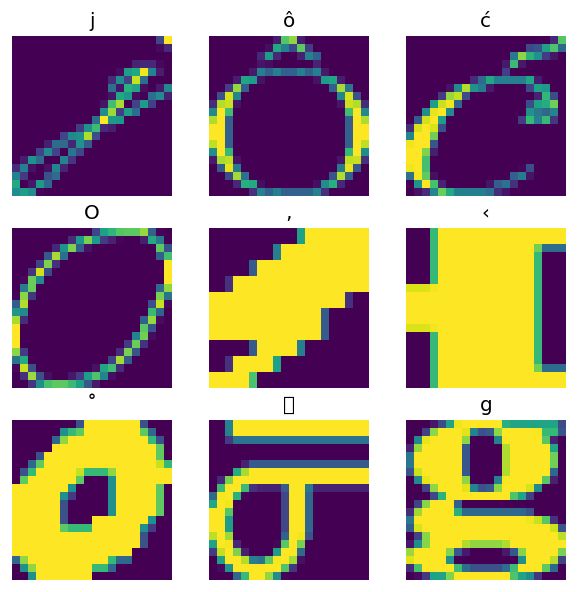

In [49]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,6), dpi=120)

for n in range(9):
  plt.subplot(3,3,n+1)
  plt.imshow(features['image'][..., n])
  plt.title(chr(features['m_label'][n]))
  plt.axis('off')

## Lower level functions

So far this tutorial has focused on the highest-level utilities for reading csv data. There are other two APIs that may be helpful for advanced users if your use-case doesn't fit the basic patterns.

* `tf.io.decode_csv`: a function for parsing lines of text into a list of CSV column tensors.
* `tf.data.experimental.CsvDataset`: a lower-level CSV dataset constructor.

This section recreates functionality provided by `tf.data.experimental.make_csv_dataset`, to demonstrate how this lower-level functionality can be used.


### `tf.io.decode_csv`

This function decodes a string, or list of strings into a list of columns.

Unlike `tf.data.experimental.make_csv_dataset` this function does not try to guess column data-types. You specify the column types by providing a list of `record_defaults` containing a value of the correct type, for each column.

To read the Titanic data **as strings** using `tf.io.decode_csv` you would say:

In [50]:
text = pathlib.Path(titanic_file_path).read_text()
lines = text.split('\n')[1:-1]

all_strings = [str()]*10
all_strings

['', '', '', '', '', '', '', '', '', '']

In [51]:
features = tf.io.decode_csv(lines, record_defaults=all_strings) 

for f in features:
  print(f"type: {f.dtype.name}, shape: {f.shape}")

type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)


To parse them with their actual types, create a list of `record_defaults` of the corresponding types: 

In [52]:
print(lines[0])

0,male,22.0,1,0,7.25,Third,unknown,Southampton,n


In [53]:
titanic_types = [int(), str(), float(), int(), int(), float(), str(), str(), str(), str()]
titanic_types

[0, '', 0.0, 0, 0, 0.0, '', '', '', '']

In [54]:
features = tf.io.decode_csv(lines, record_defaults=titanic_types) 

for f in features:
  print(f"type: {f.dtype.name}, shape: {f.shape}")

type: int32, shape: (627,)
type: string, shape: (627,)
type: float32, shape: (627,)
type: int32, shape: (627,)
type: int32, shape: (627,)
type: float32, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)


Note: It is more efficient to call `tf.io.decode_csv` on large batches of lines than on individual lines of CSV text.

### `tf.data.experimental.CsvDataset`

The `tf.data.experimental.CsvDataset` class provides a minimal CSV `Dataset` interface without the convenience features of the `tf.data.experimental.make_csv_dataset` function: column header parsing, column type-inference, automatic shuffling, file interleaving.

This constructor uses `record_defaults` the same way as `tf.io.decode_csv`:


In [55]:
simple_titanic = tf.data.experimental.CsvDataset(titanic_file_path, record_defaults=titanic_types, header=True)

for example in simple_titanic.take(1):
  print([e.numpy() for e in example])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']


The above code is basically equivalent to:

In [56]:
def decode_titanic_line(line):
  return tf.io.decode_csv(line, titanic_types)

manual_titanic = (
    # Load the lines of text
    tf.data.TextLineDataset(titanic_file_path)
    # Skip the header row.
    .skip(1)
    # Decode the line.
    .map(decode_titanic_line)
)

for example in manual_titanic.take(1):
  print([e.numpy() for e in example])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']


#### Multiple files

To parse the fonts dataset using `tf.data.experimental.CsvDataset`, you first need to determine the column types for the `record_defaults`. Start by inspecting the first row of one file:

In [57]:
font_line = pathlib.Path(font_csvs[0]).read_text().splitlines()[1]
print(font_line)

AGENCY,AGENCY FB,64258,0.400000,0,0.000000,35,21,51,22,20,20,1,1,1,21,101,210,255,255,255,255,255,255,255,255,255,255,255,255,255,255,1,1,1,93,255,255,255,176,146,146,146,146,146,146,146,146,216,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,141,141,141,182,255,255,255,172,141,141,141,115,1,1,1,1,163,255,255,255,255,255,255,255,255,255,255,255,255,255,255,209,1,1,1,1,163,255,255,255,6,6,6,96,255,255,255,74,6,6,6,5,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1

Only the first two fields are strings, the rest are integers or floats, and you can get the total number of features by counting the commas:

In [58]:
num_font_features = font_line.count(',')+1
font_column_types = [str(), str()] + [float()]*(num_font_features-2)

The `tf.data.experimental.CsvDataset` constructor can take a list of input files, but reads them sequentially. The first file in the list of CSVs is `AGENCY.csv`:

In [59]:
font_csvs[0]

'fonts/AGENCY.csv'

So, when you pass the list of files to `CsvDataset`, the records from `AGENCY.csv` are read first:

In [60]:
simple_font_ds = tf.data.experimental.CsvDataset(
    font_csvs, 
    record_defaults=font_column_types, 
    header=True)

In [61]:
for row in simple_font_ds.take(10):
  print(row[0].numpy())

b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'


To interleave multiple files, use `Dataset.interleave`.

Here's an initial dataset that contains the CSV file names: 

In [62]:
font_files = tf.data.Dataset.list_files("fonts/*.csv")

This shuffles the file names each epoch:

In [63]:
print('Epoch 1:')
for f in list(font_files)[:5]:
  print("    ", f.numpy())
print('    ...')
print()

print('Epoch 2:')
for f in list(font_files)[:5]:
  print("    ", f.numpy())
print('    ...')

Epoch 1:


     b'fonts/TAHOMA.csv'
     b'fonts/SCRIPTB.csv'
     b'fonts/SIMPLEX.csv'
     b'fonts/ONYX.csv'
     b'fonts/PALATINO.csv'
    ...

Epoch 2:


     b'fonts/FREESTYLE.csv'
     b'fonts/CORBEL.csv'
     b'fonts/VLADIMIR.csv'
     b'fonts/KRISTEN.csv'
     b'fonts/SNAP.csv'
    ...


The `interleave` method takes a `map_func` that creates a child-`Dataset` for each element of the parent-`Dataset`.

Here, you want to create a `tf.data.experimental.CsvDataset` from each element of the dataset of files:

In [64]:
def make_font_csv_ds(path):
  return tf.data.experimental.CsvDataset(
    path, 
    record_defaults=font_column_types, 
    header=True)

The `Dataset` returned by interleave returns elements by cycling over a number of the child-`Dataset`s. Note, below, how the dataset cycles over `cycle_length=3` three font files:

In [65]:
font_rows = font_files.interleave(make_font_csv_ds,
                                  cycle_length=3)

In [66]:
fonts_dict = {'font_name':[], 'character':[]}

for row in font_rows.take(10):
  fonts_dict['font_name'].append(row[0].numpy().decode())
  fonts_dict['character'].append(chr(row[2].numpy()))

pd.DataFrame(fonts_dict)

/tmpfs/tmp/ipykernel_9839/998453860.py:5: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  fonts_dict['character'].append(chr(row[2].numpy()))


,font_name,character
0,MATURA,
1,RAGE,
2,MONOTYPE,ﬂ
3,MATURA,
4,RAGE,
5,MONOTYPE,ﬁ
6,MATURA,◊
7,RAGE,◊
8,MONOTYPE,
9,MATURA,≥


#### Performance


Earlier, it was noted that `tf.io.decode_csv` is more efficient when run on a batch of strings.

It is possible to take advantage of this fact, when using large batch sizes, to improve CSV loading performance (but try [caching](#caching) first).

With the built-in loader 20, 2048-example batches take about 17s. 

In [67]:
BATCH_SIZE=2048
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = "fonts/*.csv",
    batch_size=BATCH_SIZE, num_epochs=1,
    num_parallel_reads=100)

In [68]:
%%time
for i,batch in enumerate(fonts_ds.take(20)):
  print('.',end='')

print()

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


CPU times: user 34.9 s, sys: 4.82 s, total: 39.7 s
Wall time: 14.9 s


Passing **batches of text lines** to`decode_csv` runs faster, in about 5s:

In [69]:
fonts_files = tf.data.Dataset.list_files("fonts/*.csv")
fonts_lines = fonts_files.interleave(
    lambda fname:tf.data.TextLineDataset(fname).skip(1), 
    cycle_length=100).batch(BATCH_SIZE)

fonts_fast = fonts_lines.map(lambda x: tf.io.decode_csv(x, record_defaults=font_column_types))

In [70]:
%%time
for i,batch in enumerate(fonts_fast.take(20)):
  print('.',end='')

print()

..................

..
CPU times: user 3.38 s, sys: 20.2 ms, total: 3.4 s
Wall time: 663 ms


For another example of increasing CSV performance by using large batches, refer to the [Overfit and underfit tutorial](../keras/overfit_and_underfit.ipynb).

This sort of approach may work, but consider other options like `Dataset.cache` and `tf.data.experimental.snapshot`, or re-encoding your data into a more streamlined format.